In [2]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


In [3]:
bioclim = pd.read_csv('data/csv/bioclim.csv')
bioclim = bioclim.drop(columns=['Unnamed: 0'])

In [4]:
crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
bioclim = pd.merge(bioclim, crta_coords_filtered, on=['lat', 'lon'])
bioclim = bioclim.drop_duplicates(subset=['lat', 'lon'])
bioclim = bioclim[bioclim['bio_13']!=-3.4e+38]
coords = bioclim[['lat', 'lon']]
bioclim = bioclim.drop(columns=['lat', 'lon'])
bioclim['group'] = 'osmia'
bioclim

,bio_13,bio_11,bio_9,bio_3,elev,bio_5,bio_6,bio_17,bio_10,bio_2,...,bio_1,bio_16,bio_8,bio_4,bio_19,bio_7,bio_14,bio_18,ndvi,group
0,82.0,1.100000,2.116667,29.925650,199,24.6,-2.3,125.0,18.533333,8.050000,...,9.683333,230.0,18.533333,710.95750,132.0,26.900000,36.0,230.0,0.157664,osmia
10,81.0,1.400000,2.483333,30.308643,117,24.9,-2.1,120.0,18.816666,8.183333,...,10.008333,227.0,18.816666,709.33014,125.0,27.000000,35.0,227.0,0.151344,osmia
45,71.0,1.800000,4.933333,31.550068,79,23.0,-1.3,129.0,17.350000,7.666666,...,9.391666,189.0,17.350000,634.90454,136.0,24.300000,35.0,189.0,0.178543,osmia
46,79.0,1.416667,2.500000,30.381304,106,25.1,-2.0,113.0,18.900000,8.233334,...,10.066667,220.0,18.900000,711.54870,121.0,27.100000,33.0,220.0,0.213319,osmia
54,74.0,2.416667,5.600000,33.741497,114,23.5,-1.0,147.0,17.450000,8.266666,...,9.758333,204.0,16.016666,611.29083,157.0,24.500000,43.0,200.0,0.289286,osmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24203,64.0,2.066667,3.233333,33.107235,200,24.7,-1.1,109.0,18.383333,8.541667,...,10.029167,182.0,16.816668,663.19977,117.0,25.800001,35.0,165.0,0.241975,osmia
24204,67.0,2.250000,3.466667,33.460560,97,25.2,-1.0,117.0,18.733334,8.766666,...,10.333333,196.0,17.200000,669.74330,129.0,26.200000,38.0,175.0,0.259833,osmia
24205,76.0,2.566667,3.800000,32.403847,92,25.3,-0.7,116.0,19.133333,8.425000,...,10.687500,215.0,17.500000,674.28120,123.0,26.000000,37.0,192.0,0.220172,osmia
24206,64.0,1.983333,3.066667,30.981182,157,23.7,-1.1,125.0,17.916666,7.683333,...,9.800000,184.0,16.333334,648.14070,143.0,24.800001,41.0,165.0,0.302638,osmia


In [5]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns=['Unnamed: 0'])
america = america[america['bio_13']!= -3.4e+38]
america_points = america[['lat', 'lon']]
america = america.drop(columns=['lat', 'lon'])
america['group'] = 'america'
column_order = bioclim.columns.tolist()
america = america[column_order]


In [6]:
combined = pd.concat([bioclim, america], ignore_index=True)
combined_points = pd.concat([coords, america_points])

In [16]:
combined_vars = combined.drop(columns=['group'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(combined_vars)
combined_scaled = pd.DataFrame(df_scaled, columns=combined_vars.columns)
combined_scaled['group'] = combined['group']

In [18]:
america_df = combined_scaled[combined_scaled['group'] == 'america'].drop('group', axis=1)
osmia_df = combined_scaled[combined_scaled['group'] == 'osmia'].drop('group', axis=1)

In [20]:
from scipy.spatial import distance
from scipy.stats import chi2

osmia_mean = osmia_df.mean()
osmia_cov = osmia_df.cov()

def mahalanobis_distance(x, mean, cov):
    x_minus_mu = x - mean
    cov_inv = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal)

# Calculating the Mahalanobis distance for each point in the 'america' group
mahal_distances = america_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

In [37]:
mahal_distances = mahal_distances.reset_index(drop=True)

In [58]:
mahal_distances_eur = osmia_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

Text(0.5, 1.0, 'distribution of mahal distances, america to eur')

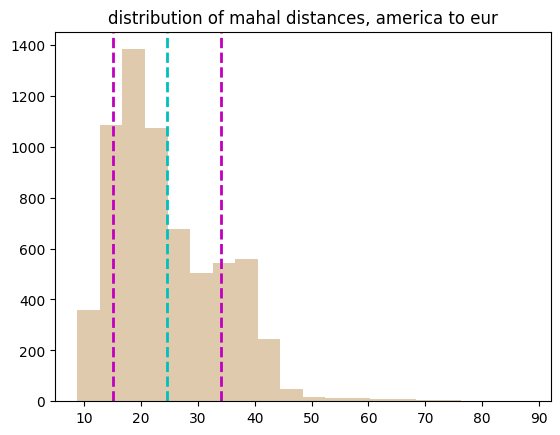

In [59]:
mean = np.mean(mahal_distances)
std_dev = np.std(mahal_distances)

# Create histogram
plt.hist(mahal_distances, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, america to eur')


Text(0.5, 1.0, 'distribution of mahal distances, eur to eur')

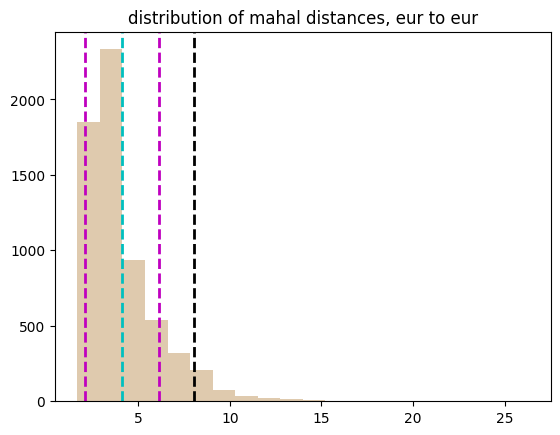

In [86]:
mean = np.mean(mahal_distances_eur)
std_dev = np.std(mahal_distances_eur)
z = 1.96
upper_bound = mean + z * std_dev

plt.hist(mahal_distances_eur, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.axvline(upper_bound, color='k', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, eur to eur')


In [87]:
upper_bound

8.049981850426551

In [69]:
min(mahal_distances)

8.759804459725503

In [42]:
america_points = america_points.reset_index(drop=True)
america_points['dist'] = mahal_distances
america_points.to_csv('america_points_mahal.csv')

In [78]:
crta_coords_filtered = crta_coords_filtered.reset_index(drop=True)
mahal_distances_eur = mahal_distances_eur.reset_index(drop=True)

crta_coords_filtered['dist'] = mahal_distances_eur

(-14641852.624039328, -6841695.90415462, 2746944.401339209, 7307496.882081329)

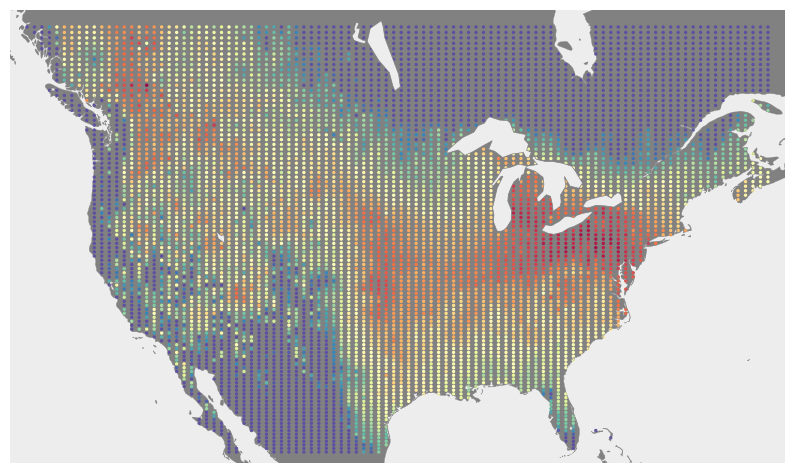

In [77]:
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

extent = [-131.53, -61.46, 24.09, 54.90]

map_projection = ccrs.Mercator() 

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')


ax.scatter(america_points['lon'], america_points['lat'], transform=ccrs.PlateCarree(), 
           c=america_points['dist'], cmap='Spectral', vmin=8.75, vmax = 30, s=2)

ax.axis('off')



In [80]:
crta_coords_filtered

,lat,lon,dist
0,51.024975,13.708278,3.097689
1,51.024975,13.791615,2.843619
2,52.274952,10.541514,2.986014
3,51.074970,13.708281,2.641206
4,50.523056,7.317993,2.223476
...,...,...,...
6489,49.725805,8.126862,NaN
6490,49.494917,8.284069,NaN
6491,49.539502,8.397228,NaN
6492,49.463856,8.164538,NaN


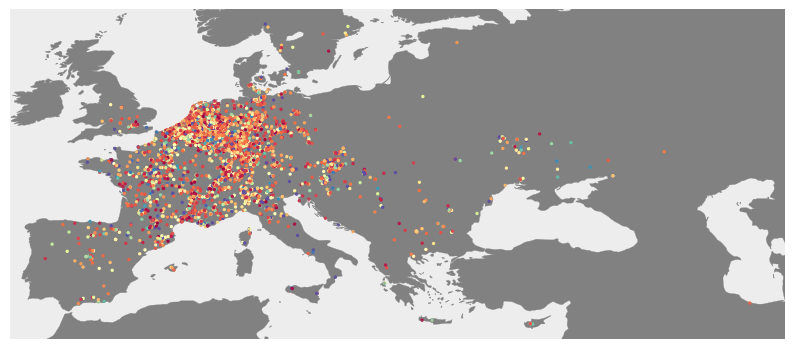

In [92]:
plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(crta_coords_filtered['lon'], crta_coords_filtered['lat'], transform=ccrs.PlateCarree(), 
           c=crta_coords_filtered['dist'], s=2, cmap='Spectral', vmin=2, vmax = 8)
ax.axis('off')

plt.savefig('eur_mahal.png', format='png', dpi=300)

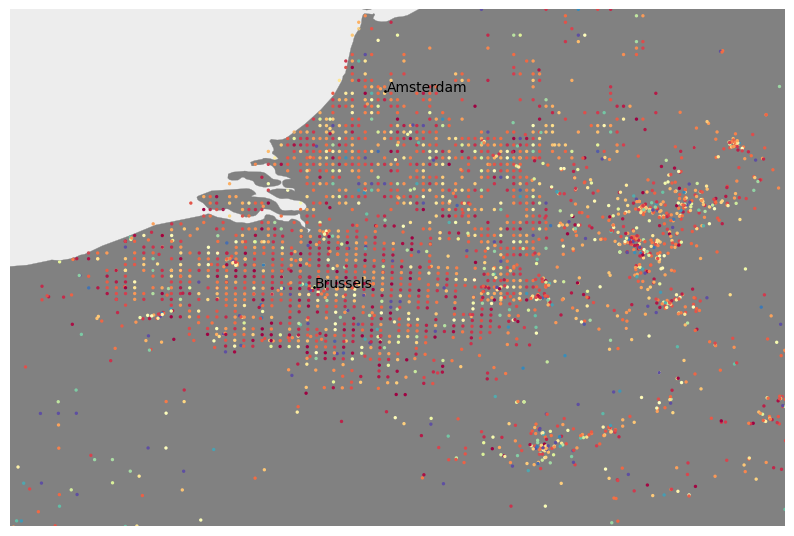

In [103]:
cities = {
    "Amsterdam": (52.3676, 4.9041),
    "Brussels": (50.8503, 4.3517),
}

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

extent = [2, 8, 49, 53]

ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed
ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(crta_coords_filtered['lon'], crta_coords_filtered['lat'], transform=ccrs.PlateCarree(), 
           c=crta_coords_filtered['dist'], s=2, cmap='Spectral', vmin=2, vmax = 8)
ax.axis('off')


for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', markersize=1, color='k', transform=ccrs.Geodetic())
    ax.text(lon + .01, lat + 0, city, transform=ccrs.Geodetic())
